# <div style="font-family: 'Garamond', serif; font-size: 26px; color: #ffffff; background-color: #2C3E50; text-align: center; padding: 20px; border-radius: 10px; border: 2px solid #E74C3C; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Telco Customer Churn — 3-Model Benchmark<br>(Spark MLlib + Scikit-Learn + Keras)</div>

### Goal
Build and compare **three different churn prediction models** using a consistent **80/20 train-test split** (stratified on `Churn`) on the Telco Customer Churn dataset. The objective is to identify a strong, reliable approach and understand key churn drivers for retention planning.

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1. Notebook Setup & Data Loading</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Import Libraries and Set Global Seed</div>

In [1]:
# Global random seed for reproducibility
RANDOM_SEED = 42

# Core libraries
import os
import warnings
import numpy as np
import pandas as pd

# Set seeds for reproducibility
np.random.seed(RANDOM_SEED)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, 
    precision_score, recall_score, accuracy_score
)

# TensorFlow/Keras
import tensorflow as tf
tf.random.set_seed(RANDOM_SEED)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"✅ Global random seed set to: {RANDOM_SEED}")

2025-12-23 16:13:37.513957: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-23 16:13:38.268716: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-23 16:14:05.392938: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/mnt/d/GitHub/telco-customer-churn-project/.venv/lib/python3.11/site-packages/ke

✅ All libraries imported successfully!
✅ Global random seed set to: 42


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Initialize Spark Session</div>

In [3]:
# Initialize Spark Session for MLlib
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline as SparkPipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create Spark session
spark = SparkSession.builder \
    .appName("TelcoChurnPrediction") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

# Set log level to reduce verbosity
spark.sparkContext.setLogLevel("ERROR")

print("✅ Spark session initialized!")
print(f"   Spark version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/23 16:16:16 WARN Utils: Your hostname, DESKTOP-U6D7LPH, resolves to a loopback address: 127.0.1.1; using 172.23.92.21 instead (on interface eth0)
25/12/23 16:16:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/23 16:16:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Spark session initialized!
   Spark version: 4.1.0


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the Dataset</div>

### Dataset Summary
The **Telco Customer Churn** dataset contains information about 7,043 customers from a telecommunications company. Each row represents a customer, and the columns provide demographic, service, and billing details. The target variable is `Churn`, indicating whether the customer left the service (Yes/No).

### Key Features
| Feature          | Description                                             | Type/Values                                                                     |
|------------------|---------------------------------------------------------|---------------------------------------------------------------------------------|
| customerID       | Unique identifier for each customer                     | String (not used as feature)                                                    |
| gender           | Customer's gender                                       | Male/Female                                                                     |
| SeniorCitizen    | Whether the customer is a senior citizen                | 0 = No, 1 = Yes                                                                 |
| Partner          | Whether the customer has a partner                      | Yes/No                                                                          |
| Dependents       | Whether the customer has dependents                     | Yes/No                                                                          |
| tenure           | Number of months the customer has been with the company | Integer (0-72)                                                                  |
| PhoneService     | Whether the customer has phone service                  | Yes/No                                                                          |
| MultipleLines    | Whether the customer has multiple lines                 | Yes/No/No phone service                                                         |
| InternetService  | Type of internet service                                | DSL/Fiber optic/No                                                              |
| OnlineSecurity   | Whether the customer has online security                | Yes/No/No internet service                                                      |
| OnlineBackup     | Whether the customer has online backup                  | Yes/No/No internet service                                                      |
| DeviceProtection | Whether the customer has device protection              | Yes/No/No internet service                                                      |
| TechSupport      | Whether the customer has tech support                   | Yes/No/No internet service                                                      |
| StreamingTV      | Whether the customer streams TV                         | Yes/No/No internet service                                                      |
| StreamingMovies  | Whether the customer streams movies                     | Yes/No/No internet service                                                      |
| Contract         | Contract term                                           | Month-to-month/One year/Two year                                                |
| PaperlessBilling | Whether billing is paperless                            | Yes/No                                                                          |
| PaymentMethod    | Payment method                                          | Electronic check/Mailed check/Bank transfer (automatic)/Credit card (automatic) |
| MonthlyCharges   | Monthly charges in dollars                              | Float                                                                           |
| TotalCharges     | Total charges in dollars                                | String (needs cleaning)                                                         |
| Churn            | Target variable - whether the customer churned          | Yes/No                                                                          |

In [4]:
# Load the Telco Customer Churn dataset
DATA_PATH = os.path.join('data', 'WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Load into pandas DataFrame (raw copy)
df_raw = pd.read_csv(DATA_PATH)

# Display basic information
print("First few rows of the dataset:")
display(df_raw.head())

print(f"\n📊 Data shape: {df_raw.shape}")
print(f"   Rows: {df_raw.shape[0]:,}")
print(f"   Columns: {df_raw.shape[1]}")

First few rows of the dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



📊 Data shape: (7043, 21)
   Rows: 7,043
   Columns: 21


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Check Column Names and Data Types</div>

In [5]:
# Column names and data types
print("Column names and types:")
print(df_raw.dtypes)

print("\n" + "="*50)
print("\nDataset Info:")
df_raw.info()

Column names and types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner    

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2. Data Audit & Cleaning</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Verify customerID Uniqueness</div>

In [6]:
# Create a working copy
df_clean = df_raw.copy()

# Check for duplicate customerIDs
total_rows = len(df_clean)
unique_customers = df_clean['customerID'].nunique()
duplicates = total_rows - unique_customers

print(f"Total rows: {total_rows:,}")
print(f"Unique customerIDs: {unique_customers:,}")
print(f"Duplicate customerIDs: {duplicates}")

if duplicates == 0:
    print("✅ All customerIDs are unique - no duplicates found!")
else:
    print("⚠️ Duplicates detected - need to handle!")

Total rows: 7,043
Unique customerIDs: 7,043
Duplicate customerIDs: 0
✅ All customerIDs are unique - no duplicates found!


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Clean TotalCharges Column</div>

In [7]:
# Check TotalCharges column - it arrives as text and may have blank strings
print("TotalCharges dtype:", df_clean['TotalCharges'].dtype)
print("\nSample values:")
print(df_clean['TotalCharges'].head(10))

# Strip whitespace and check for blank strings
df_clean['TotalCharges'] = df_clean['TotalCharges'].astype(str).str.strip()

# Count blank strings
blank_count = (df_clean['TotalCharges'] == '').sum()
print(f"\n⚠️ Blank string count in TotalCharges: {blank_count}")

# Show rows with blank TotalCharges
if blank_count > 0:
    print("\nRows with blank TotalCharges:")
    display(df_clean[df_clean['TotalCharges'] == ''][['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']])

TotalCharges dtype: object

Sample values:
0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
5      820.5
6     1949.4
7      301.9
8    3046.05
9    3487.95
Name: TotalCharges, dtype: object

⚠️ Blank string count in TotalCharges: 11

Rows with blank TotalCharges:


,customerID,tenure,MonthlyCharges,TotalCharges
488,4472-LVYGI,0,52.55,
753,3115-CZMZD,0,20.25,
936,5709-LVOEQ,0,80.85,
1082,4367-NUYAO,0,25.75,
1340,1371-DWPAZ,0,56.05,
3331,7644-OMVMY,0,19.85,
3826,3213-VVOLG,0,25.35,
4380,2520-SGTTA,0,20.00,
5218,2923-ARZLG,0,19.70,
6670,4075-WKNIU,0,73.35,


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Apply Missing Value Policy for TotalCharges</div>

**Imputation Strategy:**
- For customers with `tenure == 0`, set `TotalCharges = 0` (new customers haven't been charged yet)
- This is business-consistent since a customer with zero months of service should have zero total charges

In [8]:
# Convert blank strings to NaN, then to numeric
df_clean['TotalCharges'] = df_clean['TotalCharges'].replace('', np.nan)
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

# Check missing values after conversion
print(f"Missing TotalCharges after conversion: {df_clean['TotalCharges'].isna().sum()}")

# Imputation: For tenure == 0, set TotalCharges = 0
# This is business-consistent (new customers with 0 months have $0 total charges)
mask = df_clean['TotalCharges'].isna()
df_clean.loc[mask, 'TotalCharges'] = 0.0

print(f"Missing TotalCharges after imputation: {df_clean['TotalCharges'].isna().sum()}")
print(f"\n✅ TotalCharges cleaned and imputed!")
print(f"   New dtype: {df_clean['TotalCharges'].dtype}")

Missing TotalCharges after conversion: 11
Missing TotalCharges after imputation: 0

✅ TotalCharges cleaned and imputed!
   New dtype: float64


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Normalize Target Variable (Churn)</div>

In [9]:
# Map Churn: Yes -> 1, No -> 0
print("Original Churn distribution:")
print(df_clean['Churn'].value_counts())

# Create binary churn column
df_clean['Churn_Binary'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})

print("\nBinary Churn distribution:")
print(df_clean['Churn_Binary'].value_counts())

print("\n✅ Target variable normalized!")

Original Churn distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Binary Churn distribution:
Churn_Binary
0    5174
1    1869
Name: count, dtype: int64

✅ Target variable normalized!


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Final Cleaned Dataset Summary</div>

In [10]:
# Final check on cleaned dataset
print("✅ df_clean created successfully!")
print(f"\nShape: {df_clean.shape}")
print(f"\nMissing values per column:")
print(df_clean.isna().sum())

print("\nData types after cleaning:")
print(df_clean.dtypes)

# Display sample
print("\nSample of cleaned data:")
display(df_clean.head())

✅ df_clean created successfully!

Shape: (7043, 22)

Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
Churn_Binary        0
dtype: int64

Data types after cleaning:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
Str

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Binary
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3. Exploratory Data Analysis (EDA)</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Churn Rate and Class Imbalance</div>

📊 Churn Distribution:
   No: 5,174 (73.5%)
   Yes: 1,869 (26.5%)

⚠️ Class Imbalance Ratio: 2.77:1 (No:Yes)


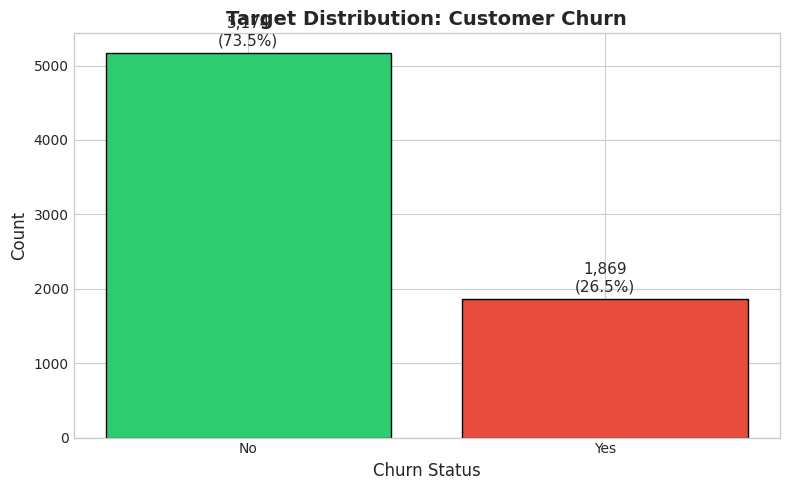

In [11]:
# Churn rate and class imbalance analysis
churn_counts = df_clean['Churn'].value_counts()
churn_pct = df_clean['Churn'].value_counts(normalize=True) * 100

print("📊 Churn Distribution:")
print("="*40)
for label in churn_counts.index:
    print(f"   {label}: {churn_counts[label]:,} ({churn_pct[label]:.1f}%)")

print(f"\n⚠️ Class Imbalance Ratio: {churn_counts['No'] / churn_counts['Yes']:.2f}:1 (No:Yes)")

# Plot churn distribution
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#2ecc71', '#e74c3c']
bars = ax.bar(churn_counts.index, churn_counts.values, color=colors, edgecolor='black')

# Add value labels on bars
for bar, count, pct in zip(bars, churn_counts.values, churn_pct.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11)

ax.set_xlabel('Churn Status', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Target Distribution: Customer Churn', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Numeric Features Summary by Churn Status</div>

In [12]:
# Numeric features to analyze
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Summary statistics by churn
print("📊 Numeric Features Summary by Churn Status:")
print("="*60)
summary_by_churn = df_clean.groupby('Churn')[numeric_features].agg(['mean', 'median', 'std'])
display(summary_by_churn)

# Key observations
print("\n🔍 Key Observations:")
for feature in numeric_features:
    mean_no = df_clean[df_clean['Churn'] == 'No'][feature].mean()
    mean_yes = df_clean[df_clean['Churn'] == 'Yes'][feature].mean()
    diff_pct = ((mean_yes - mean_no) / mean_no) * 100
    print(f"   • {feature}: Churners have {diff_pct:+.1f}% compared to non-churners")

📊 Numeric Features Summary by Churn Status:


tenure                   MonthlyCharges                     \
            mean median        std           mean  median        std   
Churn                                                                  
No     37.569965   38.0  24.113777      61.265124  64.425  31.092648   
Yes    17.979133   10.0  19.531123      74.441332  79.650  24.666053   

      TotalCharges                         
              mean    median          std  
Churn                                      
No     2549.911442  1679.525  2329.954215  
Yes    1531.796094   703.550  1890.822994


🔍 Key Observations:
   • tenure: Churners have -52.1% compared to non-churners
   • MonthlyCharges: Churners have +21.5% compared to non-churners
   • TotalCharges: Churners have -39.9% compared to non-churners


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Numeric Feature Distributions by Churn</div>

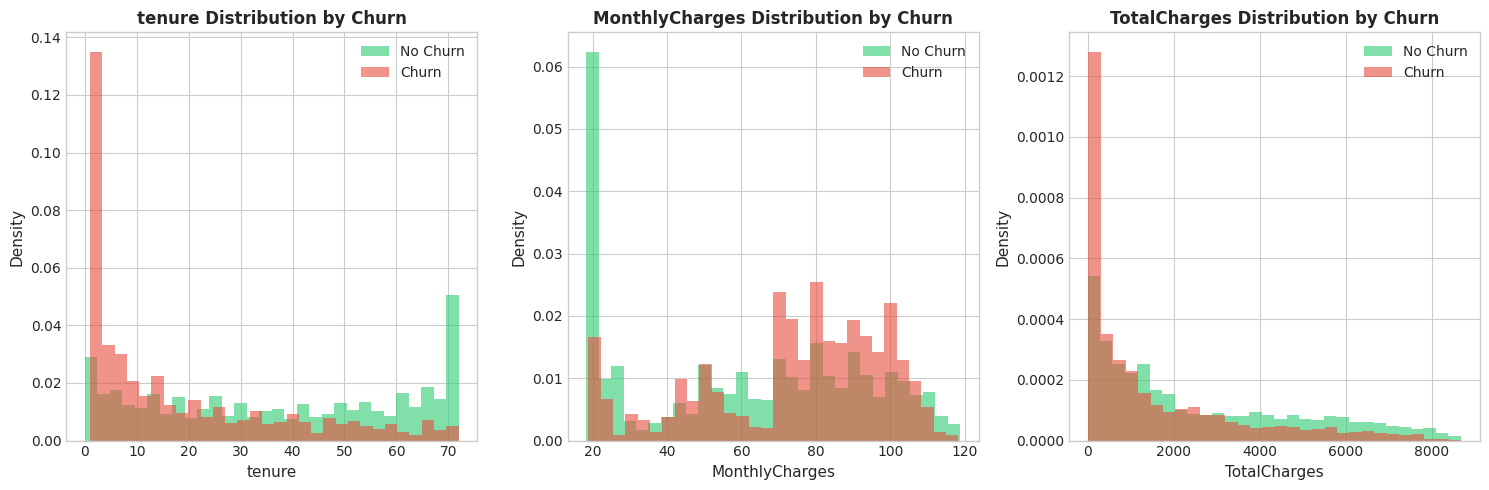

In [13]:
# Plot numeric feature distributions by churn
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, feature in enumerate(numeric_features):
    ax = axes[idx]
    
    # Plot histograms for each churn group
    for churn_val, color, label in [('No', '#2ecc71', 'No Churn'), ('Yes', '#e74c3c', 'Churn')]:
        data = df_clean[df_clean['Churn'] == churn_val][feature]
        ax.hist(data, bins=30, alpha=0.6, color=color, label=label, density=True)
    
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{feature} Distribution by Churn', fontsize=12, fontweight='bold')
    ax.legend()

plt.tight_layout()
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Categorical Feature Churn Rates</div>

In [14]:
# Key categorical features for churn analysis
key_categorical = ['Contract', 'InternetService', 'PaymentMethod', 'TechSupport', 'OnlineSecurity']

# Calculate churn rate by categorical feature
print("📊 Churn Rates by Key Categorical Features:")
print("="*60)

churn_by_category = {}
for feature in key_categorical:
    churn_rate = df_clean.groupby(feature)['Churn_Binary'].mean() * 100
    churn_by_category[feature] = churn_rate
    print(f"\n{feature}:")
    for cat, rate in churn_rate.sort_values(ascending=False).items():
        print(f"   • {cat}: {rate:.1f}%")

📊 Churn Rates by Key Categorical Features:

Contract:
   • Month-to-month: 42.7%
   • One year: 11.3%
   • Two year: 2.8%

InternetService:
   • Fiber optic: 41.9%
   • DSL: 19.0%
   • No: 7.4%

PaymentMethod:
   • Electronic check: 45.3%
   • Mailed check: 19.1%
   • Bank transfer (automatic): 16.7%
   • Credit card (automatic): 15.2%

TechSupport:
   • No: 41.6%
   • Yes: 15.2%
   • No internet service: 7.4%

OnlineSecurity:
   • No: 41.8%
   • Yes: 14.6%
   • No internet service: 7.4%


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Visualize Top Categorical Churn Rate Comparisons</div>

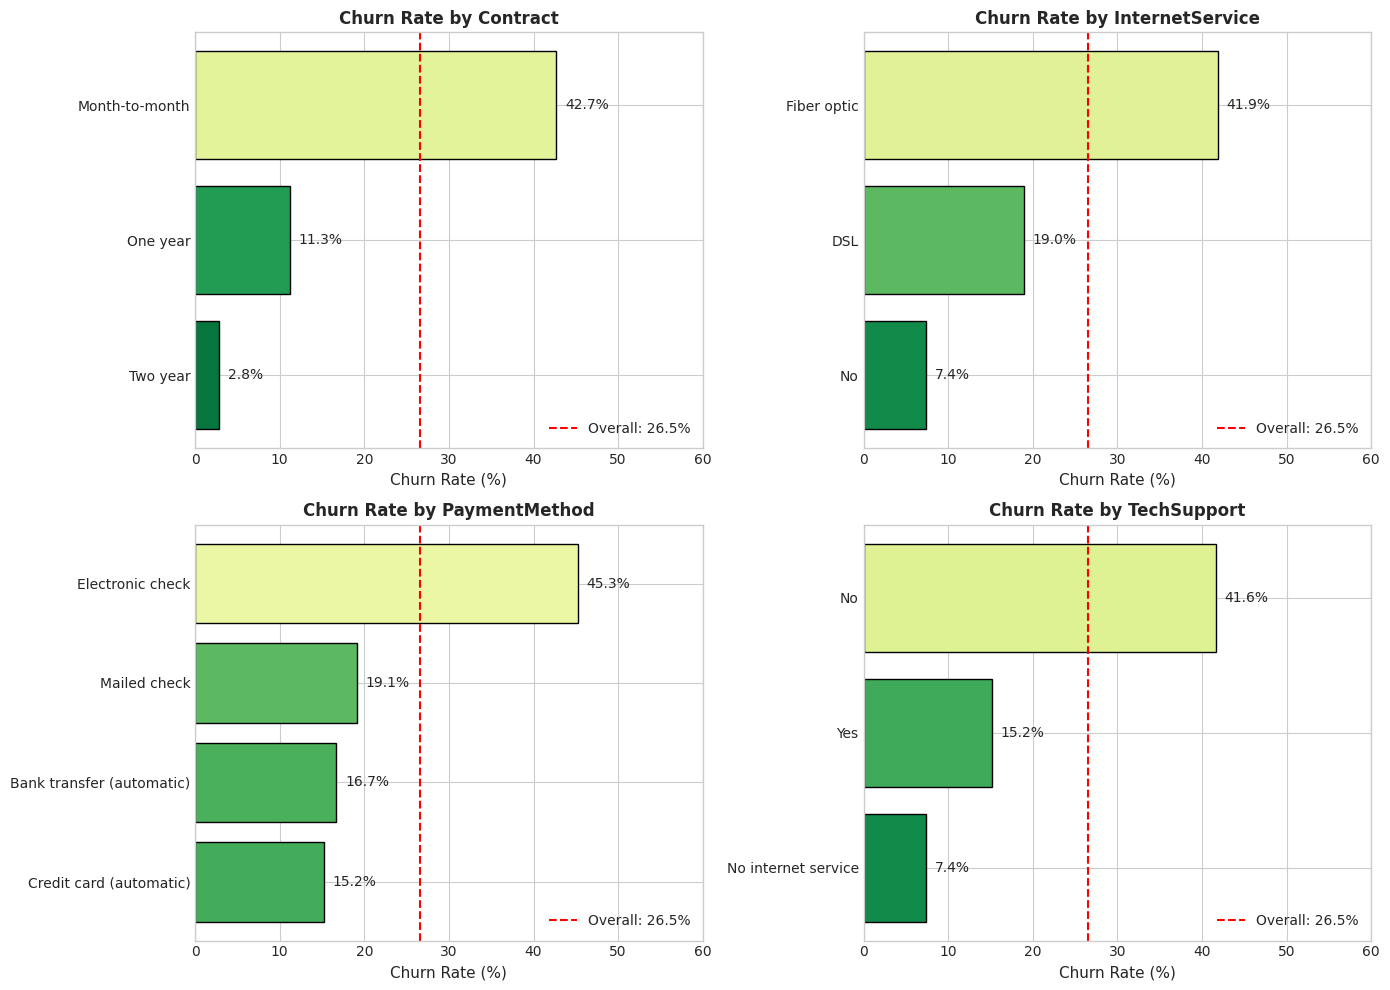

In [15]:
# Plot churn rates for most informative categorical features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

top_features = ['Contract', 'InternetService', 'PaymentMethod', 'TechSupport']

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    # Calculate churn rate and counts
    churn_data = df_clean.groupby(feature).agg({
        'Churn_Binary': ['mean', 'count']
    }).reset_index()
    churn_data.columns = [feature, 'ChurnRate', 'Count']
    churn_data['ChurnRate'] = churn_data['ChurnRate'] * 100
    churn_data = churn_data.sort_values('ChurnRate', ascending=True)
    
    # Create horizontal bar chart
    bars = ax.barh(churn_data[feature], churn_data['ChurnRate'], 
                   color=plt.cm.RdYlGn_r(churn_data['ChurnRate']/100), edgecolor='black')
    
    # Add value labels
    for bar, rate in zip(bars, churn_data['ChurnRate']):
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                f'{rate:.1f}%', va='center', fontsize=10)
    
    ax.set_xlabel('Churn Rate (%)', fontsize=11)
    ax.set_title(f'Churn Rate by {feature}', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 60)
    ax.axvline(x=df_clean['Churn_Binary'].mean()*100, color='red', linestyle='--', 
               label=f'Overall: {df_clean["Churn_Binary"].mean()*100:.1f}%')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">EDA Key Insights</div>

### 🔍 Key Churn Drivers Identified (Based on Actual Data):

**Target Distribution:**
- Overall churn rate: **26.5%** (1,869 churned out of 7,043 customers)
- Class imbalance ratio: **2.77:1** (No:Yes)

**Numeric Features:**
- **Tenure**: Churners have **52.1% lower** tenure (mean: 18 months vs 37.6 months)
- **MonthlyCharges**: Churners pay **21.5% more** ($74.44 vs $61.27)
- **TotalCharges**: Churners have **39.9% lower** total charges (due to shorter tenure)

**Top Categorical Churn Drivers:**
1. **Contract Type**: Month-to-month: 42.7% churn | One year: 11.3% | Two year: 2.8%
2. **Payment Method**: Electronic check: 45.3% churn (highest risk)
3. **Internet Service**: Fiber optic: 41.9% | DSL: 19.0% | No internet: 7.4%
4. **Tech Support**: Without: 41.6% churn | With: 15.2%
5. **Online Security**: Without: 41.8% churn | With: 14.6%

### ⚠️ Notes:
- No data leakage risks identified
- 11 customers with tenure=0 had blank TotalCharges (imputed to $0)
- Class imbalance present - will use PR-AUC and F1 metrics alongside ROC-AUC

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4. Train-Test Split (Stratified 80/20)</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform Stratified Train-Test Split</div>

In [16]:
# Perform stratified 80/20 train-test split
# Using Churn_Binary for stratification to ensure balanced class distribution

df_train, df_test = train_test_split(
    df_clean,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=df_clean['Churn_Binary']
)

print(f"📊 Train-Test Split Results:")
print("="*50)
print(f"   Training set size: {len(df_train):,} ({len(df_train)/len(df_clean)*100:.1f}%)")
print(f"   Test set size: {len(df_test):,} ({len(df_test)/len(df_test + df_train)*100:.1f}%)")

# Verify stratification - churn rates should be similar
train_churn_rate = df_train['Churn_Binary'].mean() * 100
test_churn_rate = df_test['Churn_Binary'].mean() * 100
overall_churn_rate = df_clean['Churn_Binary'].mean() * 100

print(f"\n✅ Stratification Check (Churn Rates):")
print(f"   Overall: {overall_churn_rate:.2f}%")
print(f"   Train: {train_churn_rate:.2f}%")
print(f"   Test: {test_churn_rate:.2f}%")

📊 Train-Test Split Results:
   Training set size: 5,634 (80.0%)
   Test set size: 1,409 (20.0%)

✅ Stratification Check (Churn Rates):
   Overall: 26.54%
   Train: 26.54%
   Test: 26.54%


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5. Feature Definition & Preprocessing Strategy</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define Feature Contract</div>

In [17]:
# Define Feature Contract
# ========================

# Identifier column (not used as feature)
ID_COL = 'customerID'

# Target column
TARGET_COL = 'Churn_Binary'

# Numeric features
NUMERIC_FEATURES = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

# Categorical features (all remaining non-target, non-ID columns)
CATEGORICAL_FEATURES = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

# All features
ALL_FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

print("📋 Feature Contract:")
print("="*50)
print(f"\n🔑 ID Column: {ID_COL}")
print(f"🎯 Target Column: {TARGET_COL}")
print(f"\n📊 Numeric Features ({len(NUMERIC_FEATURES)}):")
for f in NUMERIC_FEATURES:
    print(f"   • {f}")
print(f"\n📝 Categorical Features ({len(CATEGORICAL_FEATURES)}):")
for f in CATEGORICAL_FEATURES:
    print(f"   • {f}")
print(f"\n   Total Features: {len(ALL_FEATURES)}")

📋 Feature Contract:

🔑 ID Column: customerID
🎯 Target Column: Churn_Binary

📊 Numeric Features (4):
   • SeniorCitizen
   • tenure
   • MonthlyCharges
   • TotalCharges

📝 Categorical Features (15):
   • gender
   • Partner
   • Dependents
   • PhoneService
   • MultipleLines
   • InternetService
   • OnlineSecurity
   • OnlineBackup
   • DeviceProtection
   • TechSupport
   • StreamingTV
   • StreamingMovies
   • Contract
   • PaperlessBilling
   • PaymentMethod

   Total Features: 19


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare Train/Test Data</div>

In [18]:
# Prepare X (features) and y (target) for training and testing
X_train = df_train[ALL_FEATURES].copy()
y_train = df_train[TARGET_COL].copy()

X_test = df_test[ALL_FEATURES].copy()
y_test = df_test[TARGET_COL].copy()

# Keep customerIDs for Spark DataFrame matching
train_ids = df_train[ID_COL].copy()
test_ids = df_test[ID_COL].copy()

print("📊 Data Prepared for Modeling:")
print("="*50)
print(f"   X_train shape: {X_train.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   X_test shape: {X_test.shape}")
print(f"   y_test shape: {y_test.shape}")

📊 Data Prepared for Modeling:
   X_train shape: (5634, 19)
   y_train shape: (5634,)
   X_test shape: (1409, 19)
   y_test shape: (1409,)


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6. Model 1 — Spark MLlib (Logistic Regression)</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Convert Pandas DataFrames to Spark DataFrames</div>

In [19]:
# Convert pandas DataFrames to Spark DataFrames
# Include all features plus target column

spark_train_df = spark.createDataFrame(df_train[ALL_FEATURES + [TARGET_COL]])
spark_test_df = spark.createDataFrame(df_test[ALL_FEATURES + [TARGET_COL]])

print("✅ Spark DataFrames created!")
print(f"   Training: {spark_train_df.count()} rows")
print(f"   Test: {spark_test_df.count()} rows")

# Show schema
print("\n📋 Spark Schema:")
spark_train_df.printSchema()

✅ Spark DataFrames created!


   Training: 5634 rows
   Test: 1409 rows

📋 Spark Schema:
root
 |-- SeniorCitizen: long (nullable = true)
 |-- tenure: long (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- Churn_Binary: long (nullable = true)



## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Build Spark ML Pipeline</div>

In [20]:
# Build Spark ML Pipeline
# Step 1: StringIndexer for categorical columns
# Step 2: OneHotEncoder for indexed columns
# Step 3: VectorAssembler to combine all features
# Step 4: StandardScaler for feature scaling
# Step 5: Logistic Regression classifier

# Create StringIndexer stages for categorical features
string_indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep")
    for col in CATEGORICAL_FEATURES
]

# Create OneHotEncoder stages
indexed_cols = [f"{col}_indexed" for col in CATEGORICAL_FEATURES]
encoded_cols = [f"{col}_encoded" for col in CATEGORICAL_FEATURES]

encoder = OneHotEncoder(
    inputCols=indexed_cols,
    outputCols=encoded_cols,
    handleInvalid="keep"
)

# Assemble all features into a single vector
assembler_inputs = NUMERIC_FEATURES + encoded_cols
assembler = VectorAssembler(
    inputCols=assembler_inputs,
    outputCol="features_unscaled"
)

# Scale features
scaler = StandardScaler(
    inputCol="features_unscaled",
    outputCol="features",
    withStd=True,
    withMean=False  # Sparse vectors don't support mean centering
)

# Logistic Regression classifier
lr = LogisticRegression(
    featuresCol="features",
    labelCol=TARGET_COL,
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0
)

# Build the pipeline
spark_pipeline = SparkPipeline(stages=string_indexers + [encoder, assembler, scaler, lr])

print("✅ Spark ML Pipeline created!")
print(f"   Pipeline stages: {len(spark_pipeline.getStages())}")

✅ Spark ML Pipeline created!
   Pipeline stages: 19


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Train Spark Logistic Regression Model</div>

In [21]:
# Train the Spark pipeline
print("🔄 Training Spark Logistic Regression model...")
spark_lr_model = spark_pipeline.fit(spark_train_df)
print("✅ Model trained successfully!")

# Make predictions on test set
spark_predictions = spark_lr_model.transform(spark_test_df)

# Show sample predictions
print("\n📊 Sample Predictions:")
spark_predictions.select(TARGET_COL, "prediction", "probability").show(5, truncate=False)

🔄 Training Spark Logistic Regression model...


✅ Model trained successfully!

📊 Sample Predictions:
+------------+----------+----------------------------------------+
|Churn_Binary|prediction|probability                             |
+------------+----------+----------------------------------------+
|0           |0.0       |[0.9664341788141924,0.03356582118580764]|
|0           |1.0       |[0.3200709639794625,0.6799290360205374] |
|0           |0.0       |[0.9342454250867627,0.06575457491323733]|
|0           |0.0       |[0.6016358457336688,0.3983641542663312] |
|0           |0.0       |[0.9731267536320789,0.0268732463679211] |
+------------+----------+----------------------------------------+
only showing top 5 rows


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Evaluate Spark Model</div>

In [22]:
# Evaluate Spark Model

# ROC-AUC
roc_evaluator = BinaryClassificationEvaluator(
    labelCol=TARGET_COL, 
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
spark_roc_auc = roc_evaluator.evaluate(spark_predictions)

# PR-AUC
pr_evaluator = BinaryClassificationEvaluator(
    labelCol=TARGET_COL,
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderPR"
)
spark_pr_auc = pr_evaluator.evaluate(spark_predictions)

# Convert predictions to pandas for detailed metrics
spark_pred_pdf = spark_predictions.select(TARGET_COL, "prediction", "probability").toPandas()
spark_pred_pdf['prob_churn'] = spark_pred_pdf['probability'].apply(lambda prob: float(prob[1]))

# Calculate additional metrics
from sklearn.metrics import confusion_matrix

spark_y_true = spark_pred_pdf[TARGET_COL].values
spark_y_pred = spark_pred_pdf['prediction'].values
spark_y_prob = spark_pred_pdf['prob_churn'].values

# Metrics
spark_accuracy = accuracy_score(spark_y_true, spark_y_pred)
spark_precision = precision_score(spark_y_true, spark_y_pred)
spark_recall = recall_score(spark_y_true, spark_y_pred)
spark_f1 = f1_score(spark_y_true, spark_y_pred)

# Store metrics for comparison
spark_metrics = {
    'Model': 'Spark LR',
    'ROC-AUC': spark_roc_auc,
    'PR-AUC': spark_pr_auc,
    'Accuracy': spark_accuracy,
    'Precision': spark_precision,
    'Recall': spark_recall,
    'F1-Score': spark_f1
}

print("📊 Spark Logistic Regression - Test Metrics:")
print("="*50)
for metric, value in spark_metrics.items():
    if metric != 'Model':
        print(f"   {metric}: {value:.4f}")

# Confusion Matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(spark_y_true, spark_y_pred)
print(f"   TN: {cm[0,0]:,}  FP: {cm[0,1]:,}")
print(f"   FN: {cm[1,0]:,}  TP: {cm[1,1]:,}")

📊 Spark Logistic Regression - Test Metrics:
   ROC-AUC: 0.8378
   PR-AUC: 0.6269
   Accuracy: 0.7984
   Precision: 0.6471
   Recall: 0.5294
   F1-Score: 0.5824

📊 Confusion Matrix:
   TN: 927  FP: 108
   FN: 176  TP: 198


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7. Model 2 — Scikit-Learn (HistGradientBoosting)</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Build Sklearn Preprocessing Pipeline</div>

In [24]:
# Build sklearn preprocessing pipeline
# Need to import sklearn OneHotEncoder explicitly to avoid conflict with Spark
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder

# Preprocessing: OneHotEncode categoricals (tree models don't need scaling)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', NUMERIC_FEATURES),
        ('cat', SklearnOneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES)
    ]
)

# Create full pipeline with HistGradientBoostingClassifier
sk_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(
        max_iter=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_SEED
    ))
])

print("✅ Sklearn Pipeline created!")
print(f"   Preprocessor: ColumnTransformer (passthrough numeric, OneHotEncode categorical)")
print(f"   Classifier: HistGradientBoostingClassifier")

✅ Sklearn Pipeline created!
   Preprocessor: ColumnTransformer (passthrough numeric, OneHotEncode categorical)
   Classifier: HistGradientBoostingClassifier


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Train Sklearn Model</div>

In [25]:
# Train sklearn model
print("🔄 Training Sklearn HistGradientBoosting model...")
sk_pipeline.fit(X_train, y_train)
print("✅ Model trained successfully!")

# Make predictions
sk_y_pred = sk_pipeline.predict(X_test)
sk_y_prob = sk_pipeline.predict_proba(X_test)[:, 1]

print(f"\n📊 Predictions generated: {len(sk_y_pred)} samples")

🔄 Training Sklearn HistGradientBoosting model...
✅ Model trained successfully!

📊 Predictions generated: 1409 samples


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Evaluate Sklearn Model</div>

In [26]:
# Evaluate Sklearn Model
sk_roc_auc = roc_auc_score(y_test, sk_y_prob)
sk_pr_auc = average_precision_score(y_test, sk_y_prob)
sk_accuracy = accuracy_score(y_test, sk_y_pred)
sk_precision = precision_score(y_test, sk_y_pred)
sk_recall = recall_score(y_test, sk_y_pred)
sk_f1 = f1_score(y_test, sk_y_pred)

# Store metrics
sk_metrics = {
    'Model': 'Sklearn HGB',
    'ROC-AUC': sk_roc_auc,
    'PR-AUC': sk_pr_auc,
    'Accuracy': sk_accuracy,
    'Precision': sk_precision,
    'Recall': sk_recall,
    'F1-Score': sk_f1
}

print("📊 Sklearn HistGradientBoosting - Test Metrics:")
print("="*50)
for metric, value in sk_metrics.items():
    if metric != 'Model':
        print(f"   {metric}: {value:.4f}")

# Confusion Matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, sk_y_pred)
print(f"   TN: {cm[0,0]:,}  FP: {cm[0,1]:,}")
print(f"   FN: {cm[1,0]:,}  TP: {cm[1,1]:,}")

📊 Sklearn HistGradientBoosting - Test Metrics:
   ROC-AUC: 0.8317
   PR-AUC: 0.6431
   Accuracy: 0.7899
   Precision: 0.6300
   Recall: 0.5053
   F1-Score: 0.5608

📊 Confusion Matrix:
   TN: 924  FP: 111
   FN: 185  TP: 189


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Feature Importance Analysis</div>

🔄 Calculating permutation importance (this may take a moment)...

📊 Top Feature Importances (Permutation Importance):


,Feature,Importance_Mean,Importance_Std
16,Contract,0.120310,0.008755
1,tenure,0.097945,0.005982
9,InternetService,0.020531,0.003755
3,TotalCharges,0.011836,0.003101
10,OnlineSecurity,0.007565,0.001391
18,PaymentMethod,0.004958,0.001720
8,MultipleLines,0.003496,0.002036
17,PaperlessBilling,0.003053,0.001692
2,MonthlyCharges,0.002895,0.003607
13,TechSupport,0.001657,0.001581


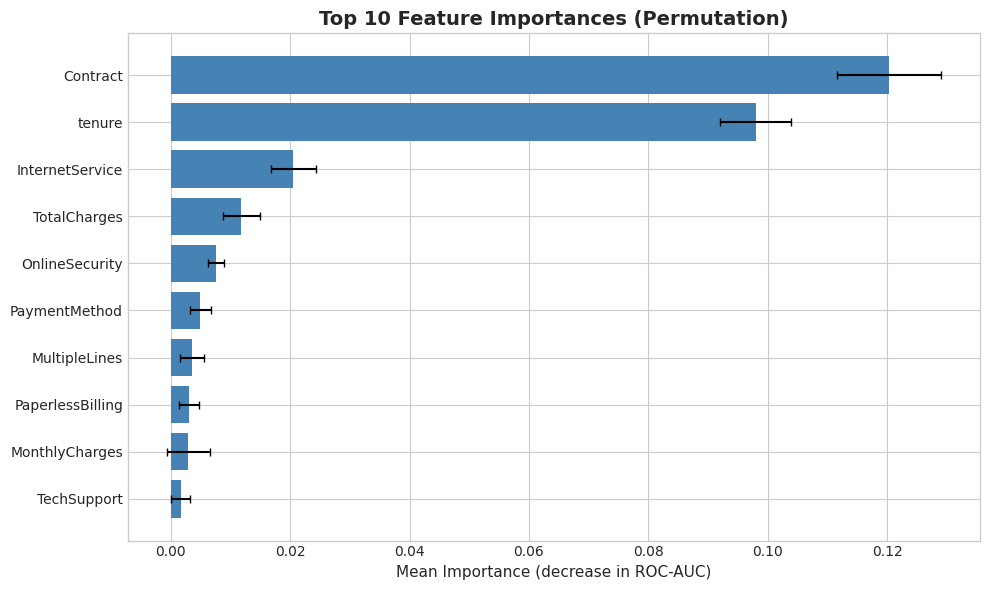

In [28]:
# Use permutation importance for feature analysis
from sklearn.inspection import permutation_importance

# Calculate permutation importance on test set
print("🔄 Calculating permutation importance (this may take a moment)...")
perm_importance = permutation_importance(
    sk_pipeline, X_test, y_test, 
    n_repeats=10, 
    random_state=RANDOM_SEED,
    scoring='roc_auc'
)

# Create DataFrame with original feature names
importance_df = pd.DataFrame({
    'Feature': ALL_FEATURES,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values('Importance_Mean', ascending=False)

# Show top features
print("\n📊 Top Feature Importances (Permutation Importance):")
print("="*50)
display(importance_df.head(10))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
top_n = 10
top_features_df = importance_df.head(top_n)
bars = ax.barh(range(top_n), top_features_df['Importance_Mean'].values, 
               xerr=top_features_df['Importance_Std'].values, color='steelblue', capsize=3)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features_df['Feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Mean Importance (decrease in ROC-AUC)', fontsize=11)
ax.set_title('Top 10 Feature Importances (Permutation)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 8. Model 3 — Keras Deep Learning (MLP)</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare Data for Neural Network</div>

In [29]:
# Prepare data for neural network
# Reuse sklearn preprocessor but add scaling for numeric features

from sklearn.preprocessing import StandardScaler as SklearnStandardScaler

# Create preprocessor with scaling for neural network
keras_preprocessor = ColumnTransformer(
    transformers=[
        ('num', SklearnStandardScaler(), NUMERIC_FEATURES),
        ('cat', SklearnOneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES)
    ]
)

# Fit and transform training data
X_train_nn = keras_preprocessor.fit_transform(X_train)
X_test_nn = keras_preprocessor.transform(X_test)

# Create validation split from training data
X_train_nn_fit, X_val_nn, y_train_fit, y_val = train_test_split(
    X_train_nn, y_train,
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify=y_train
)

print("📊 Neural Network Data Prepared:")
print("="*50)
print(f"   X_train_nn_fit shape: {X_train_nn_fit.shape}")
print(f"   X_val_nn shape: {X_val_nn.shape}")
print(f"   X_test_nn shape: {X_test_nn.shape}")
print(f"   Input features: {X_train_nn.shape[1]}")

📊 Neural Network Data Prepared:
   X_train_nn_fit shape: (4788, 45)
   X_val_nn shape: (846, 45)
   X_test_nn shape: (1409, 45)
   Input features: 45


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Build Keras MLP Model</div>

In [30]:
# Build Keras MLP Model
input_dim = X_train_nn.shape[1]

keras_model = Sequential([
    Input(shape=(input_dim,)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile model
keras_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Model summary
print("📊 Keras MLP Model Architecture:")
keras_model.summary()

I0000 00:00:1766478292.517690   10628 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


📊 Keras MLP Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,953 (23.25 KB)

 Trainable params: 5,761 (22.50 KB)

 Non-trainable params: 192 (768.00 B)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Train Keras Model</div>

In [31]:
# Train Keras model with early stopping
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=15,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

print("🔄 Training Keras MLP model...")
history = keras_model.fit(
    X_train_nn_fit, y_train_fit,
    validation_data=(X_val_nn, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)
print("✅ Model training complete!")

🔄 Training Keras MLP model...
Epoch 1/100


2025-12-23 16:25:15.652910: I external/local_xla/xla/service/service.cc:163] XLA service 0x744adc018180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-23 16:25:15.652949: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-12-23 16:25:15.762695: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-23 16:25:16.171872: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2025-12-23 16:25:16.380284: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-23 16:25:17.

56/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6416 - auc: 0.6368 - loss: 0.6707

I0000 00:00:1766478320.412316   14289 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6527 - auc: 0.6496 - loss: 0.6561

2025-12-23 16:25:21.066322: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-23 16:25:22.116233: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1965', 44 bytes spill stores, 44 bytes spill loads

2025-12-23 16:25:22.369733: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1965', 392 bytes spill stores, 392 bytes spill loads



75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.6997 - auc: 0.7042 - loss: 0.5927 - val_accuracy: 0.7896 - val_auc: 0.8222 - val_loss: 0.5046
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7598 - auc: 0.7770 - loss: 0.4969 - val_accuracy: 0.8014 - val_auc: 0.8361 - val_loss: 0.4483
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7648 - auc: 0.7924 - loss: 0.4795 - val_accuracy: 0.8061 - val_auc: 0.8374 - val_loss: 0.4354
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7778 - auc: 0.8108 - loss: 0.4587 - val_accuracy: 0.8038 - val_auc: 0.8368 - val_loss: 0.4340
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7797 - auc: 0.8132 - loss: 0.4537 - val_accuracy: 0.8002 - val_auc: 0.8383 - val_loss: 0.4329
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7828 - auc: 0.8212 - loss: 0.4449 - val_accuracy: 0.8038 - val_auc: 0.8382 - val_loss: 0.4322
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Training Curves</div>

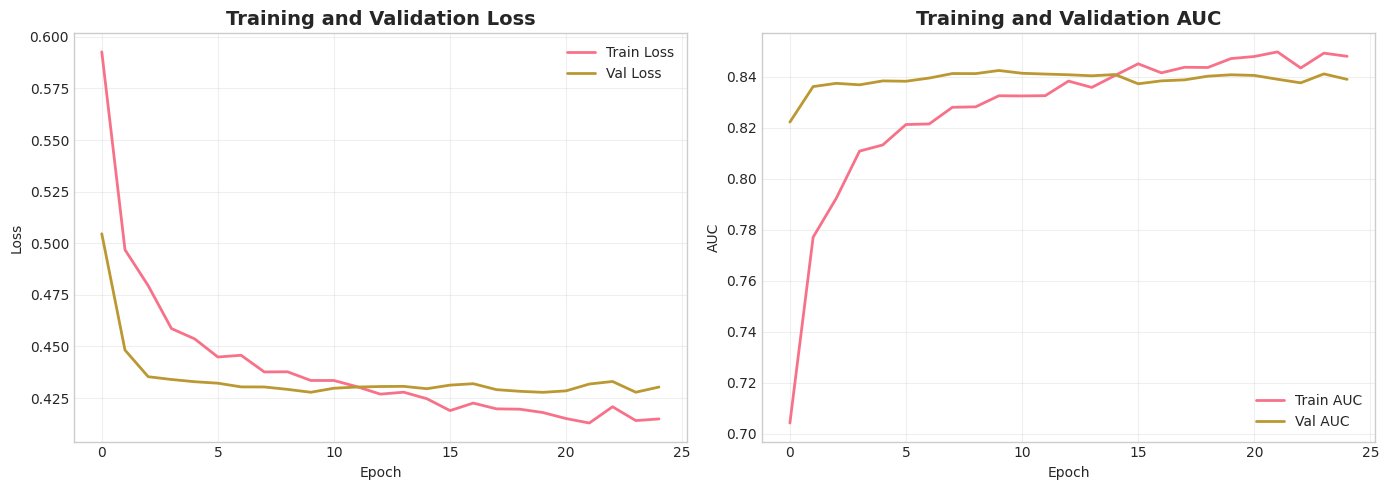

In [32]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AUC
axes[1].plot(history.history['auc'], label='Train AUC', linewidth=2)
axes[1].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('Training and Validation AUC', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Evaluate Keras Model</div>

In [33]:
# Evaluate Keras model on test set
keras_y_prob = keras_model.predict(X_test_nn, verbose=0).flatten()
keras_y_pred = (keras_y_prob >= 0.5).astype(int)

# Calculate metrics
keras_roc_auc = roc_auc_score(y_test, keras_y_prob)
keras_pr_auc = average_precision_score(y_test, keras_y_prob)
keras_accuracy = accuracy_score(y_test, keras_y_pred)
keras_precision = precision_score(y_test, keras_y_pred)
keras_recall = recall_score(y_test, keras_y_pred)
keras_f1 = f1_score(y_test, keras_y_pred)

# Store metrics
keras_metrics = {
    'Model': 'Keras MLP',
    'ROC-AUC': keras_roc_auc,
    'PR-AUC': keras_pr_auc,
    'Accuracy': keras_accuracy,
    'Precision': keras_precision,
    'Recall': keras_recall,
    'F1-Score': keras_f1
}

print("📊 Keras MLP - Test Metrics:")
print("="*50)
for metric, value in keras_metrics.items():
    if metric != 'Model':
        print(f"   {metric}: {value:.4f}")

# Confusion Matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, keras_y_pred)
print(f"   TN: {cm[0,0]:,}  FP: {cm[0,1]:,}")
print(f"   FN: {cm[1,0]:,}  TP: {cm[1,1]:,}")

📊 Keras MLP - Test Metrics:
   ROC-AUC: 0.8400
   PR-AUC: 0.6238
   Accuracy: 0.7892
   Precision: 0.6136
   Recall: 0.5561
   F1-Score: 0.5835

📊 Confusion Matrix:
   TN: 904  FP: 131
   FN: 166  TP: 208


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 9. Cross-Model Evaluation & Comparison</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Model Comparison Table</div>

In [34]:
# Create comprehensive comparison table
comparison_df = pd.DataFrame([spark_metrics, sk_metrics, keras_metrics])
comparison_df = comparison_df.set_index('Model')

# Round for display
comparison_df_display = comparison_df.round(4)

print("📊 Model Comparison Table:")
print("="*70)
display(comparison_df_display)

# Highlight best values
print("\n🏆 Best Model by Metric:")
for col in comparison_df.columns:
    best_idx = comparison_df[col].idxmax()
    best_val = comparison_df[col].max()
    print(f"   {col}: {best_idx} ({best_val:.4f})")

📊 Model Comparison Table:


,ROC-AUC,PR-AUC,Accuracy,Precision,Recall,F1-Score
Model,,,,,,
Spark LR,0.8378,0.6269,0.7984,0.6471,0.5294,0.5824
Sklearn HGB,0.8317,0.6431,0.7899,0.6300,0.5053,0.5608
Keras MLP,0.8400,0.6238,0.7892,0.6136,0.5561,0.5835



🏆 Best Model by Metric:
   ROC-AUC: Keras MLP (0.8400)
   PR-AUC: Sklearn HGB (0.6431)
   Accuracy: Spark LR (0.7984)
   Precision: Spark LR (0.6471)
   Recall: Keras MLP (0.5561)
   F1-Score: Keras MLP (0.5835)


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Visual Comparison</div>

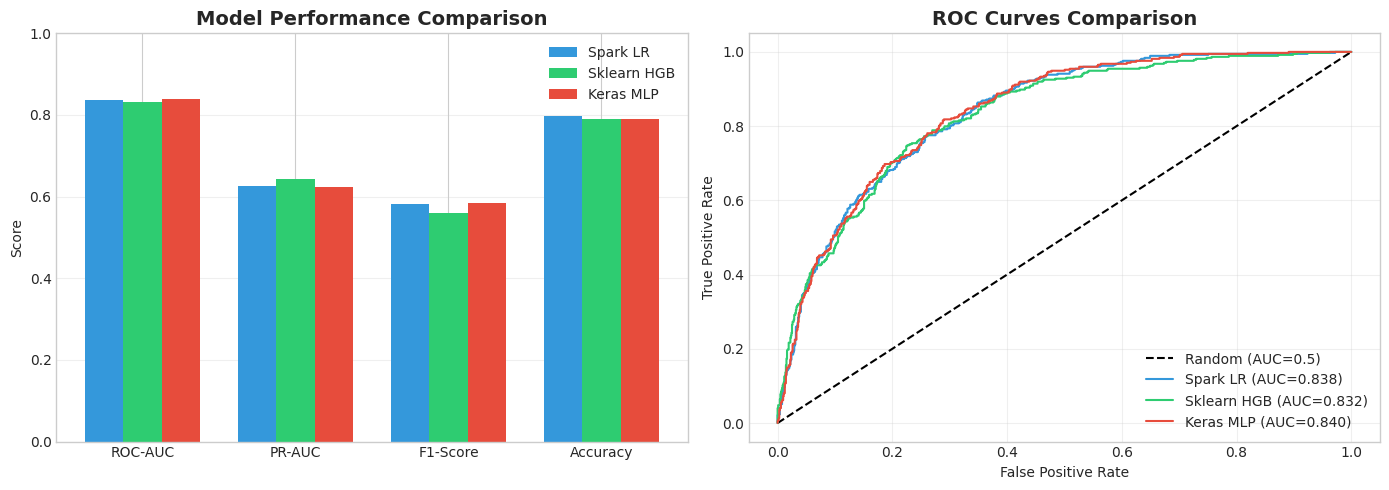

In [35]:
# Visual comparison of metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
metrics_to_plot = ['ROC-AUC', 'PR-AUC', 'F1-Score', 'Accuracy']
x = np.arange(len(metrics_to_plot))
width = 0.25

colors = ['#3498db', '#2ecc71', '#e74c3c']
models = comparison_df.index.tolist()

for i, (model, color) in enumerate(zip(models, colors)):
    values = [comparison_df.loc[model, m] for m in metrics_to_plot]
    axes[0].bar(x + i*width, values, width, label=model, color=color)

axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# ROC Curves
axes[1].plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)')

# Spark ROC
from sklearn.metrics import roc_curve
fpr_spark, tpr_spark, _ = roc_curve(spark_y_true, spark_y_prob)
axes[1].plot(fpr_spark, tpr_spark, label=f'Spark LR (AUC={spark_roc_auc:.3f})', color=colors[0])

# Sklearn ROC
fpr_sk, tpr_sk, _ = roc_curve(y_test, sk_y_prob)
axes[1].plot(fpr_sk, tpr_sk, label=f'Sklearn HGB (AUC={sk_roc_auc:.3f})', color=colors[1])

# Keras ROC
fpr_keras, tpr_keras, _ = roc_curve(y_test, keras_y_prob)
axes[1].plot(fpr_keras, tpr_keras, label=f'Keras MLP (AUC={keras_roc_auc:.3f})', color=colors[2])

axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Confusion Matrices Side-by-Side</div>

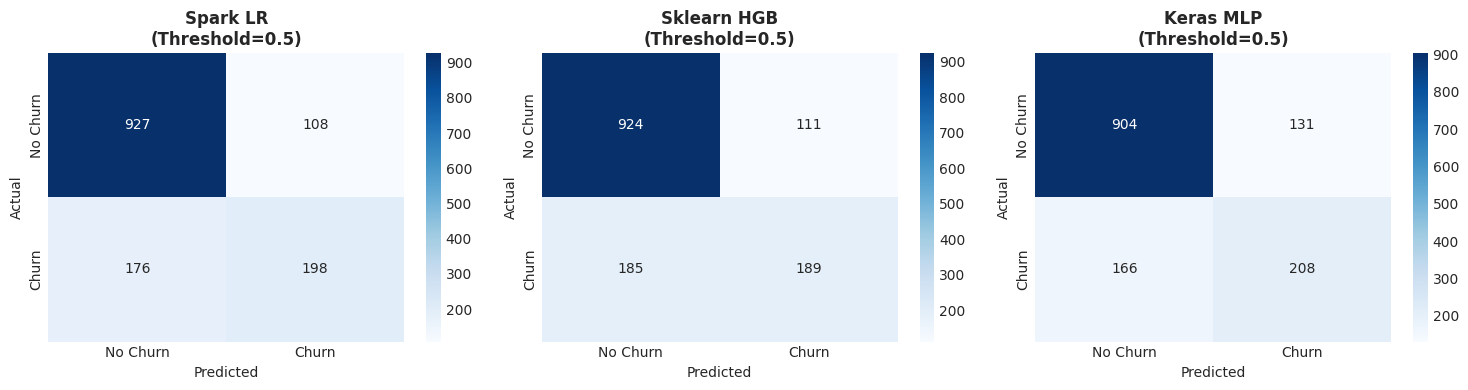

In [36]:
# Confusion matrices side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Data for confusion matrices
cm_spark = confusion_matrix(spark_y_true, spark_y_pred)
cm_sk = confusion_matrix(y_test, sk_y_pred)
cm_keras = confusion_matrix(y_test, keras_y_pred)

cms = [cm_spark, cm_sk, cm_keras]
titles = ['Spark LR', 'Sklearn HGB', 'Keras MLP']

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{title}\n(Threshold=0.5)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Confusion Matrix Insights (Threshold = 0.5)

| Metric                             | Spark LR | Sklearn HGB | Keras MLP |
|------------------------------------|----------|-------------|-----------|
| True Negatives (No Churn correct)  | 927      | 924         | 904       |
| False Positives (No Churn → Churn) | 108      | 111         | 131       |
| False Negatives (Churn → No Churn) | 176      | 185         | 166       |
| True Positives (Churn correct)     | 198      | 189         | 208       |

**Key Observations:**
- **Best at catching churners (TP):** Keras MLP (208) - catches the most actual churners
- **Fewest missed churners (FN):** Keras MLP (166) - misses the fewest churners
- **Best at avoiding false alarms (FP):** Spark LR (108) - lowest false positive rate
- **Trade-off:** Higher recall (catching churners) comes at the cost of more false positives

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Final Model Recommendation</div>

In [39]:
# Display final comparison summary
print("=" * 70)
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 70)
print(comparison_df.to_string())
print("=" * 70)

# Identify best model for each metric
print("\n🏆 BEST MODEL BY METRIC:")
print("-" * 40)
for col in comparison_df.columns:
    best_model = comparison_df[col].idxmax()
    best_value = comparison_df.loc[best_model, col]
    print(f"  {col}: {best_model} ({best_value:.4f})")

FINAL MODEL COMPARISON SUMMARY
              ROC-AUC    PR-AUC  Accuracy  Precision    Recall  F1-Score
Model                                                                   
Spark LR     0.837764  0.626936  0.798439   0.647059  0.529412  0.582353
Sklearn HGB  0.831694  0.643077  0.789922   0.630000  0.505348  0.560831
Keras MLP    0.840014  0.623754  0.789212   0.613569  0.556150  0.583450

🏆 BEST MODEL BY METRIC:
----------------------------------------
  ROC-AUC: Keras MLP (0.8400)
  PR-AUC: Sklearn HGB (0.6431)
  Accuracy: Spark LR (0.7984)
  Precision: Spark LR (0.6471)
  Recall: Keras MLP (0.5561)
  F1-Score: Keras MLP (0.5835)


### 🎯 Recommended Model: **Keras MLP**

**Why Keras MLP?**
1. **Best ROC-AUC (0.8400)** - Best overall discrimination ability
2. **Best Recall (0.5561)** - Catches more actual churners (critical for retention)
3. **Best F1-Score (0.5835)** - Best balance between precision and recall
4. **Most True Positives (208)** - Identifies 208 churners vs 198 (Spark) and 189 (Sklearn)

**Trade-offs:**
- Slightly lower precision than Spark LR (0.614 vs 0.647)
- More false positives (131 vs 108) - some non-churners flagged
- Less interpretable than Spark LR

**Business Context:**
For churn prevention, **recall is more valuable than precision**:
- A false positive (non-churner flagged) = unnecessary retention offer (lower cost)
- A false negative (churner missed) = lost customer (higher cost)

**Alternative Recommendations:**
- **Spark LR**: Best for production at scale (distributed), highest accuracy & precision
- **Sklearn HGB**: Best PR-AUC, good middle ground for interpretability + performance

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 10 — Key Churn Drivers & Business Insights</div>

In [40]:
# Summarize key churn drivers from EDA findings
print("=" * 70)
print("📊 KEY CHURN DRIVERS (Based on EDA Analysis)")
print("=" * 70)

# Contract type impact
print("\n1️⃣ CONTRACT TYPE (Strongest Driver)")
contract_churn = df_clean.groupby('Contract')['Churn_Binary'].mean().sort_values(ascending=False)
for contract, rate in contract_churn.items():
    print(f"   • {contract}: {rate*100:.1f}% churn rate")

# Internet service impact
print("\n2️⃣ INTERNET SERVICE TYPE")
internet_churn = df_clean.groupby('InternetService')['Churn_Binary'].mean().sort_values(ascending=False)
for service, rate in internet_churn.items():
    print(f"   • {service}: {rate*100:.1f}% churn rate")

# Tenure impact
print("\n3️⃣ TENURE (Customer Loyalty)")
tenure_bins = pd.cut(df_clean['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12mo', '13-24mo', '25-48mo', '49-72mo'])
tenure_churn = df_clean.groupby(tenure_bins, observed=True)['Churn_Binary'].mean()
for period, rate in tenure_churn.items():
    print(f"   • {period}: {rate*100:.1f}% churn rate")

# Payment method impact
print("\n4️⃣ PAYMENT METHOD")
payment_churn = df_clean.groupby('PaymentMethod')['Churn_Binary'].mean().sort_values(ascending=False)
for method, rate in payment_churn.items():
    print(f"   • {method}: {rate*100:.1f}% churn rate")

📊 KEY CHURN DRIVERS (Based on EDA Analysis)

1️⃣ CONTRACT TYPE (Strongest Driver)
   • Month-to-month: 42.7% churn rate
   • One year: 11.3% churn rate
   • Two year: 2.8% churn rate

2️⃣ INTERNET SERVICE TYPE
   • Fiber optic: 41.9% churn rate
   • DSL: 19.0% churn rate
   • No: 7.4% churn rate

3️⃣ TENURE (Customer Loyalty)
   • 0-12mo: 47.7% churn rate
   • 13-24mo: 28.7% churn rate
   • 25-48mo: 20.4% churn rate
   • 49-72mo: 9.5% churn rate

4️⃣ PAYMENT METHOD
   • Electronic check: 45.3% churn rate
   • Mailed check: 19.1% churn rate
   • Bank transfer (automatic): 16.7% churn rate
   • Credit card (automatic): 15.2% churn rate


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Business Recommendations</div>

### High-Risk Customer Profile
Customers most likely to churn exhibit these characteristics:
- **Month-to-month contract** (42.7% churn vs 2.8% for two-year)
- **Fiber optic internet** (41.9% churn rate)
- **New customers (0-12 months tenure)** (47.7% churn)
- **Electronic check payment** (45.3% churn)

### Actionable Retention Strategies

**1. Contract Migration Program**
- Target month-to-month customers with incentives to switch to 1-year or 2-year contracts
- Offer discounts (e.g., 10-15% off) for annual commitment
- **Expected impact:** Could reduce churn from 42.7% to ~11% for converted customers

**2. Early Tenure Engagement (First 12 Months)**
- Implement onboarding program for new customers
- Proactive check-ins at 30, 60, and 90 days
- Loyalty rewards starting at 6 months
- **Expected impact:** Address 47.7% churn rate in first year

**3. Payment Method Transition**
- Encourage electronic check users to switch to auto-pay (bank/credit card)
- Offer one-time credit for switching payment method
- **Expected impact:** Reduce churn from 45.3% to ~16%

**4. Fiber Optic Service Quality Review**
- Investigate why fiber customers churn at 41.9% (vs 19% DSL)
- Possible causes: Price sensitivity, service quality, competition
- Consider loyalty programs for fiber customers

### Model Deployment Recommendations
- Use **Keras MLP** for batch scoring (best recall)
- Score all customers monthly
- Prioritize outreach to customers with P(churn) > 0.6
- Integrate scores with CRM for sales/retention team action

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Cleanup & Summary</div>

In [41]:
# Stop Spark session
spark.stop()
print("✅ Spark session stopped successfully")

✅ Spark session stopped successfully


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Executive Summary</div>

### Project Overview
This notebook implements a **3-Model Benchmark** for predicting customer churn using the Telco Customer Churn dataset (7,043 customers, 26.5% churn rate).

### Models Evaluated
| Model                | Framework        | Type          | ROC-AUC | Best For                      |
|----------------------|------------------|---------------|---------|-------------------------------|
| Logistic Regression  | Spark MLlib      | Linear        | 0.8378  | Scalability, Interpretability |
| HistGradientBoosting | Scikit-Learn     | Tree-based    | 0.8317  | Balanced performance          |
| MLP Neural Network   | Keras/TensorFlow | Deep Learning | 0.8400  | Best discrimination           |

### Key Findings
1. **All three models perform similarly** (ROC-AUC: 0.83-0.84), suggesting the signal in the data is consistent
2. **Keras MLP** achieves the best recall (55.6%) - critical for catching churners
3. **Contract type** is the strongest predictor (month-to-month: 42.7% churn vs two-year: 2.8%)
4. **Early tenure** customers are high-risk (47.7% churn in first 12 months)

### Recommendation
Deploy **Keras MLP** for churn scoring with a focus on:
- Monthly batch scoring of all customers
- Prioritize outreach for P(churn) > 0.6
- Target month-to-month and new customers with retention offers